## GPytorch scaling test: Parallel partial emulation versus Multitask GP

This notebook compares the computational cost of two strategies for multi-task (multioutput) Gaussian Process regression:
- Multitask GPs: learns both intra- and inter-task similarities (already implemented in `gpytorch`)
- Parallel partial GPs: learns a single kernel for all tasks (new)

In [1]:
# import statements
import math
import numpy as np
import time
import torch
import gpytorch

from matplotlib import pyplot as plt
from matplotlib.ticker import MultipleLocator

In [2]:
# multitask GP
class MultitaskGPModel(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood, rank=1):
        super(MultitaskGPModel, self).__init__(train_x, train_y, likelihood)
        self.mean_module = gpytorch.means.MultitaskMean(
            gpytorch.means.ConstantMean(), num_tasks=train_y.shape[1]
        )
        self.covar_module = gpytorch.kernels.MultitaskKernel(
            gpytorch.kernels.RBFKernel(), num_tasks=train_y.shape[1], rank=rank
        )

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultitaskMultivariateNormal(mean_x, covar_x)

In [3]:
# parallel partial GP
class ParallelPartialGPModel(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood):
        super(ParallelPartialGPModel, self).__init__(train_x, train_y, likelihood)
        self.mean_module = gpytorch.means.MultitaskMean(
            gpytorch.means.ZeroMean(), num_tasks=train_y.shape[1]
        )
        self.covar_module = gpytorch.kernels.ParallelPartialKernel(
            gpytorch.kernels.RBFKernel(), num_tasks=train_y.shape[1]
        )

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultitaskMultivariateNormal(mean_x, covar_x)

In [4]:
# number of outputs to test
n_outputs = [2 + i for i in range(0, 20, 2)]

In [5]:
# methods to test
methods = []
methods.append(("multitask GP", MultitaskGPModel))
methods.append(("parallel partial GP", ParallelPartialGPModel))

In [6]:
# generate training data
train_x = torch.linspace(0, 1, 1000)
test_x = torch.linspace(0, 1, 100)
train_y_all = [
    torch.sin(train_x * (2 * math.pi)) + (2 * torch.rand(1) - 1) * math.pi + torch.randn(train_x.size()) * 0.2 for _ in range(max(n_outputs))
]

In [7]:
# time single GP evaluation
n_reps = 10
times = {}
for n_output in n_outputs:
    print(f"{n_output:6d} outputs |", end=" ")
    for name, cls in methods:
        train_y = torch.stack(train_y_all[:n_output], -1)
        likelihood = gpytorch.likelihoods.MultitaskGaussianLikelihood(num_tasks=train_y.shape[1])
        model = cls(train_x, train_y, likelihood)
        model.eval()
        likelihood.eval()
        with torch.no_grad(), gpytorch.settings.fast_pred_var():
            likelihood(model(test_x)) # precompile
            t_durations = list()
            for reps in range(10):
                t_start = time.time()
                likelihood(model(test_x))
                t_durations.append(time.time() - t_start)
            t_duration = np.min(t_durations)
            print(f"{cls.__name__} {t_duration:5.3f} |", end=" ")
            if not name in times:
                times[name] = list()
            times[name].append(t_duration)
    print()

     2 outputs | MultitaskGPModel 0.004 | ParallelPartialGPModel 0.002 | 
     4 outputs | MultitaskGPModel 0.005 | ParallelPartialGPModel 0.002 | 
     6 outputs | MultitaskGPModel 0.009 | ParallelPartialGPModel 0.003 | 
     8 outputs | MultitaskGPModel 0.032 | ParallelPartialGPModel 0.003 | 
    10 outputs | MultitaskGPModel 0.079 | ParallelPartialGPModel 0.002 | 
    12 outputs | MultitaskGPModel 0.121 | ParallelPartialGPModel 0.003 | 
    14 outputs | MultitaskGPModel 0.164 | ParallelPartialGPModel 0.003 | 
    16 outputs | MultitaskGPModel 0.265 | ParallelPartialGPModel 0.003 | 
    18 outputs | MultitaskGPModel 0.270 | ParallelPartialGPModel 0.003 | 
    20 outputs | MultitaskGPModel 0.329 | ParallelPartialGPModel 0.003 | 


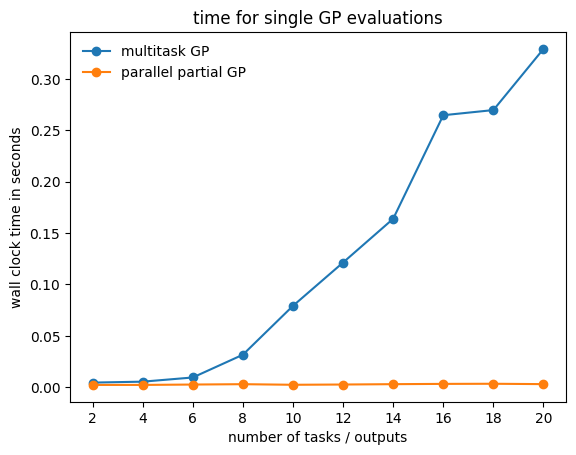

In [8]:
# plot times
_, ax = plt.subplots()
for label, t in times.items():
    ax.plot(n_outputs, t, marker="o", label=label)
ax.legend(frameon=False)
ax.set_xlabel("number of tasks / outputs")
ax.set_ylabel("wall clock time in seconds")
ax.set_title("time for single GP evaluations")
ax.xaxis.set_major_locator(MultipleLocator(2))
plt.show()